In [ ]:
# %pip install pyarrow

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import logging
import os
import time
import math
from tqdm import tqdm
from typing import Tuple, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import datetime

In [5]:
from torch.cuda.amp import autocast, GradScaler

In [6]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)


In [8]:
class IntrusionDetectionDataset(Dataset):
    """Dataset class for IDS data."""
    
    def __init__(self, X_cnn, X_lstm, y):
        self.X_cnn = torch.FloatTensor(X_cnn)
        self.X_lstm = torch.FloatTensor(X_lstm)
        #self.y = torch.LongTensor(y)
        self.y = torch.LongTensor(y.values if isinstance(y, pd.Series) else y)

        
    def __len__(self):
        return len(self.y)
        
    def __getitem__(self, idx):
        return self.X_cnn[idx], self.X_lstm[idx], self.y[idx]


In [9]:
import torch
import torch.nn as nn

class HybridCNNBiLSTM(nn.Module):
    """
    Improved Hybrid CNN-BiLSTM model with enhanced regularization to combat overfitting.
    """
    def __init__(self, cnn_input_shape, lstm_input_shape, num_classes):
        super(HybridCNNBiLSTM, self).__init__()
        
        # CNN branch with Batch Normalization and Dropout2d for spatial dropout
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout2d(0.25)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout2d(0.25)
        
        # Calculate the flattened CNN output size after two pooling layers
        cnn_output_height = cnn_input_shape[1] // 4  # divided by 2 twice
        cnn_output_width = cnn_input_shape[2] // 4
        self.cnn_output_size = 64 * cnn_output_height * cnn_output_width
        
        # BiLSTM branch with dropout between layers
        self.lstm1 = nn.LSTM(
            input_size=lstm_input_shape[1],
            hidden_size=64,
            batch_first=True,
            bidirectional=True
        )
        # Dropout layer applied on LSTM outputs to prevent overfitting
        self.dropout_lstm = nn.Dropout(0.3)
        self.lstm2 = nn.LSTM(
            input_size=128,  # 64 (hidden) * 2 (bidirectional)
            hidden_size=32,
            batch_first=True,
            bidirectional=True
        )
        
        # Combined fully connected layers
        # Note: The BiLSTM output is 32*2 = 64 features (from last time step)
        combined_size = self.cnn_output_size + 64
        self.fc1 = nn.Linear(combined_size, 128)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        
        # Activation function
        self.relu = nn.ReLU()
        
    def forward(self, x_cnn, x_lstm):
        # CNN branch
        x1 = self.conv1(x_cnn)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.pool1(x1)
        x1 = self.dropout1(x1)
        
        x1 = self.conv2(x1)
        x1 = self.bn2(x1)
        x1 = self.relu(x1)
        x1 = self.pool2(x1)
        x1 = self.dropout2(x1)
        x1 = x1.view(x1.size(0), -1)  # Flatten
        
        # BiLSTM branch
        x2, _ = self.lstm1(x_lstm)
        x2 = self.dropout_lstm(x2)
        x2, _ = self.lstm2(x2)
        x2 = x2[:, -1, :]  # Use the output from the last time step
        
        # Feature fusion and classification
        combined = torch.cat((x1, x2), dim=1)
        x = self.fc1(combined)
        x = self.relu(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        
        return x

In [10]:
class IntrusionDetectionSystem:
    def __init__(self, config: Dict[str, Any]):
        """
        Initialize the IDS with configuration parameters.
        
        Args:
            config: Dictionary containing model configuration
        """
        self.config = config
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        
    def load_data(self, filepath: str) -> pd.DataFrame:
        """
        Load and perform initial cleaning of the CICIDS2017 dataset.
        
        Args:
            filepath: Path to the CSV file
            
        Returns:
            Cleaned DataFrame
        """
        try:
            logger.info("Loading pre-processed dataset...")
            print("\nReading parquet dataset file...")
            # Load the fused dataset
            df = pd.read_parquet('cic-collection.parquet')

            labels_to_keep = ['Benign', 'DoS','DDoS', 'Bruteforce', 'Botnet']
            df = df[df['ClassLabel'].isin(labels_to_keep)]

            df = df.drop(columns='Label') #we will only use the detailed attacks
            
            df['ClassLabel'] = df['ClassLabel'].astype('category').cat.codes
            
            positive_correlation_features = [
                'Avg Packet Size', 'Packet Length Mean', 'Bwd Packet Length Std', 'Packet Length Variance',
                'Bwd Packet Length Max', 'Packet Length Max', 'Packet Length Std', 'Fwd Packet Length Mean',
                'Avg Fwd Segment Size', 'Flow Bytes/s', 'Avg Bwd Segment Size', 'Bwd Packet Length Mean',
                'Fwd Packets/s', 'Flow Packets/s', 'Init Fwd Win Bytes', 'Subflow Fwd Bytes',
                'Fwd Packets Length Total', 'Fwd Act Data Packets', 'Total Fwd Packets', 'Subflow Fwd Packets'
                # Add more features as needed
            ]
            df = df[positive_correlation_features + ['ClassLabel']]
            
            #UNDERSAMPLING PART - MAYBE CAUSING OVERFITTING
            # # Get the counts of each label
            # label_counts = df['ClassLabel'].value_counts()

            # # Set the target count to the count of label 2
            # target_count = label_counts.min()

            # # Undersample labels 0 and 1 to the target count
            # undersampled_df = pd.concat([
            #     df[df['ClassLabel'] == 0].sample(target_count, replace=False),
            #     df[df['ClassLabel'] == 1].sample(target_count, replace=False),
            #     df[df['ClassLabel'] == 2],
            #     df[df['ClassLabel'] == 3].sample(target_count, replace=False)
            # ], axis=0)

            # # Shuffle the undersampled DataFrame to mix the labels
            # undersampled_df = undersampled_df.sample(frac=1).reset_index(drop=True)

            # df = undersampled_df
            
            
            
            
            # Log dataset information
            logger.info(f"Loaded {len(df):,} rows and {len(df.columns):,} columns")
            logger.info(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
            
            return df
            
        except Exception as e:
            logger.error(f"Error loading data: {str(e)}")
            raise
            
    def preprocess_data(self, df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
        """
        Preprocess the data for training.
        
        Args:
            df: Input DataFrame
            
        Returns:
            Tuple of (features, labels)
        """
        try:
            print("\nPreprocessing data...")
            # Separate features and labels
            X = df.drop('ClassLabel', axis=1)
            y = df['ClassLabel']
            
            # Scale features
            print("Scaling features...")
            X_scaled = self.scaler.fit_transform(X)
            
            # # Encode labels (already done in load_data function)
            # print("Encoding labels...")
            # y_encoded = self.label_encoder.fit_transform(y)
            
            # Log class distribution
            label_mapping = {0: 'Benign', 1: 'DoS', 2: 'DDoS', 3: 'Bruteforce', 4: 'Botnet'}
            unique_labels, counts = np.unique(y, return_counts=True)
            logger.info("\nClass distribution:")
            for encoded_label, count in zip(unique_labels, counts):
                original_label = label_mapping[encoded_label]
                logger.info(f"{original_label}: {count:,} samples")
            
            return X_scaled, y
            
        except Exception as e:
            logger.error(f"Error preprocessing data: {str(e)}")
            raise

    def reshape_data(self, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Reshape data for CNN and BiLSTM branches with memory efficiency.
        
        Args:
            X: Input features
            
        Returns:
            Tuple of (CNN_shaped_data, LSTM_shaped_data)
        """
        try:
            print("\nReshaping data for neural networks...")
            
            # Convert to float32 to reduce memory by half
            X = X.astype(np.float32)
            
            # Process in chunks for both CNN and LSTM
            chunk_size = 10000  # Adjust based on your available memory
            num_chunks = (X.shape[0] + chunk_size - 1) // chunk_size
            
            # Calculate dimensions once
            features_sqrt = math.ceil(np.sqrt(X.shape[1]))
            padding_cnn = features_sqrt ** 2 - X.shape[1]
            
            # For LSTM reshaping
            timesteps = self.config['timesteps']
            if X.shape[1] % timesteps != 0:
                new_total = math.ceil(X.shape[1] / timesteps) * timesteps
                padding_lstm = new_total - X.shape[1]
            else:
                new_total = X.shape[1]
                padding_lstm = 0
                
            # Pre-allocate output arrays
            X_cnn_shape = (X.shape[0], 1, features_sqrt, features_sqrt)
            X_lstm_shape = (X.shape[0], timesteps, new_total // timesteps)
            
            X_cnn = np.zeros(X_cnn_shape, dtype=np.float32)
            X_lstm = np.zeros(X_lstm_shape, dtype=np.float32)
            
            # Process in chunks
            for i in range(num_chunks):
                start_idx = i * chunk_size
                end_idx = min((i + 1) * chunk_size, X.shape[0])
                chunk = X[start_idx:end_idx]
                
                # CNN reshaping for this chunk
                if padding_cnn > 0:
                    chunk_padded_cnn = np.pad(chunk, ((0, 0), (0, padding_cnn)), mode='constant')
                else:
                    chunk_padded_cnn = chunk.copy()
                    
                X_cnn[start_idx:end_idx] = chunk_padded_cnn.reshape(-1, 1, features_sqrt, features_sqrt)
                
                # LSTM reshaping for this chunk
                if padding_lstm > 0:
                    chunk_padded_lstm = np.pad(chunk, ((0, 0), (0, padding_lstm)), mode='constant')
                else:
                    chunk_padded_lstm = chunk.copy()
                    
                X_lstm[start_idx:end_idx] = chunk_padded_lstm.reshape(-1, timesteps, new_total // timesteps)
                
                # Force garbage collection after each chunk
                del chunk, chunk_padded_cnn, chunk_padded_lstm
                if i % 10 == 0:  # Every 10 chunks
                    import gc
                    gc.collect()
                    print(f"Processed chunk {i+1}/{num_chunks}")
            
            return X_cnn, X_lstm
                
        except Exception as e:
            logger.error(f"Error reshaping data: {str(e)}")
            raise        
    
            
    def handle_class_imbalance(self, X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Handle class imbalance using Focal Loss preparation.
        This approach computes class weights for Focal Loss instead of using SMOTE.
        
        Args:
            X: Features
            y: Labels
            
        Returns:
            Tuple of (original_features, original_labels)
        """
        try:
            print("\nHandling class imbalance...")
            start_time = time.time()
            
            logger.info("Class distribution:")
            unique_labels, counts = np.unique(y, return_counts=True)
            for label, count in zip(unique_labels, counts):
                logger.info(f"Class {label}: {count:,} samples")
            
            # Calculate class weights for Focal Loss
            total_samples = len(y)
            n_classes = len(unique_labels)
            class_weights = {}
            
            # Calculate inverse frequency weights
            for label, count in zip(unique_labels, counts):
                # Class weight is inversely proportional to frequency
                weight = total_samples / (n_classes * count)
                # Store to be used in the model training
                class_weights[int(label)] = weight
                logger.info(f"Class {label} weight: {weight:.4f}")
            
            # Store class weights as an attribute to be used during training
            self.class_weights = class_weights
            
            duration = time.time() - start_time
            logger.info(f"Class weight calculation completed in {duration:.2f} seconds")
            
            # Return original data - no resampling needed with Focal Loss
            return X, y
                
        except Exception as e:
            logger.error(f"Error handling class imbalance: {str(e)}")
            raise
    
    def create_dataloaders(self, X_train_cnn, X_train_lstm, y_train, 
                      X_val_cnn, X_val_lstm, y_val,
                      X_test_cnn, X_test_lstm, y_test):
        """
        Create PyTorch DataLoaders for training, validation and testing.
        
        Returns:
            Tuple of (train_loader, val_loader, test_loader)
        """
        try:
            print("\nCreating PyTorch DataLoaders...")
            
            # Create datasets
            train_dataset = IntrusionDetectionDataset(X_train_cnn, X_train_lstm, y_train)
            val_dataset = IntrusionDetectionDataset(X_val_cnn, X_val_lstm, y_val)
            test_dataset = IntrusionDetectionDataset(X_test_cnn, X_test_lstm, y_test)
            
            # Get system-specific settings
            import platform
            is_windows = platform.system() == 'Windows'
            
            # On Windows, multiprocessing needs to use 'spawn' method
            if is_windows:
                import torch.multiprocessing as mp
                mp.set_start_method('spawn', force=True)
            
            # Determine safe num_workers based on system
            if is_windows:
                # On Windows, num_workers often causes issues, use 0 for safety
                # or set to 1 for minimal parallelism
                safe_workers = 0
            else:
                # On Unix systems, we can use the configured value
                safe_workers = self.config.get('num_workers', 0)
            
            print(f"Using {safe_workers} DataLoader workers (adjusted for platform compatibility)")
            
            # Create dataloaders using config parameters with platform-specific adjustments
            train_loader = DataLoader(
                train_dataset, 
                batch_size=self.config.get('batch_size'),
                shuffle=True,
                num_workers=safe_workers,
                pin_memory=self.config.get('pin_memory', True),
                persistent_workers=safe_workers > 0,  # Keep workers alive between iterations if using workers
                prefetch_factor=2 if safe_workers > 0 else None,  # Prefetch 2 batches per worker
            )
            
            val_loader = DataLoader(
                val_dataset, 
                batch_size=self.config.get('batch_size'), 
                shuffle=False,
                num_workers=safe_workers,
                pin_memory=self.config.get('pin_memory', True),
                persistent_workers=safe_workers > 0,
                prefetch_factor=2 if safe_workers > 0 else None,
            )
            
            test_loader = DataLoader(
                test_dataset, 
                batch_size=self.config.get('batch_size'), 
                shuffle=False,
                num_workers=safe_workers,
                pin_memory=self.config.get('pin_memory', True),
                persistent_workers=safe_workers > 0,
                prefetch_factor=2 if safe_workers > 0 else None,
            )
            
            logger.info(f"Created DataLoaders with {len(train_loader)} training batches, "
                    f"{len(val_loader)} validation batches, and {len(test_loader)} test batches")
            
            return train_loader, val_loader, test_loader
            
        except Exception as e:
            logger.error(f"Error creating DataLoaders: {str(e)}")
            raise
    #insert here        
    def train_and_evaluate(self, train_loader, val_loader, test_loader, cnn_input_shape, lstm_input_shape, num_classes):
        """Train the model and evaluate its performance using Automatic Mixed Precision."""
        try:
            print("\nStarting model training with Automatic Mixed Precision...")
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            
            # Initialize model
            model = HybridCNNBiLSTM(cnn_input_shape, lstm_input_shape, num_classes).to(device)
            
            # Set up optimizer and scheduler with gradient accumulation
            optimizer = optim.Adam(model.parameters(), lr=self.config['learning_rate'], weight_decay=1e-4)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, verbose=True)

            if(self.config['balanced'] == False):
                # Replacing standard CrossEntropyLoss with weighted version
                class_weights = torch.FloatTensor([self.class_weights[i] for i in range(len(self.class_weights))]).to(device)
                criterion = nn.CrossEntropyLoss(weight=class_weights)
            
            else:
                criterion = nn.CrossEntropyLoss()
            # Check if mixed precision should be used (based on config and availability)
            use_amp = self.config.get('mixed_precision', False) and torch.cuda.is_available()
            
            # Initialize the scaler for AMP if needed
            if use_amp:
                print("Using Automatic Mixed Precision (AMP) for training")
                # Use the updated import pattern for autocast to avoid deprecation warning
                from torch.amp import autocast
                scaler = torch.cuda.amp.GradScaler()
            else:
                print("Using full precision for training")
                scaler = None
            
            # Validate dataset before training
            print("Validating dataset for correct class indices...")
            try:
                for batch_idx, (x_cnn, x_lstm, targets) in enumerate(train_loader):
                    min_target = targets.min().item()
                    max_target = targets.max().item()
                    if min_target < 0 or max_target >= num_classes:
                        raise ValueError(f"Invalid targets in batch {batch_idx}: range [{min_target}, {max_target}], "
                                        f"should be [0, {num_classes-1}]")
                    
                    # Only check a few batches to save time
                    if batch_idx >= 5:
                        break
                print("Dataset validation complete - no invalid class indices found")
            except Exception as e:
                logger.error(f"Dataset validation error: {str(e)}")
                raise
            
            # Training loop with memory management
            history = []
            best_val_loss = float('inf')
            accumulation_steps = 8  # Accumulate gradients over multiple batches
            
            for epoch in range(self.config['epochs']):
                # Training
                model.train()
                train_loss = 0.0
                train_correct = 0
                train_total = 0
                
                progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), 
                                desc=f"Epoch {epoch+1}/{self.config['epochs']}")
                
                optimizer.zero_grad()  # Reset gradients at the start of each epoch
                
                for batch_idx, (x_cnn, x_lstm, targets) in progress_bar:
                    try:
                        # Sanity check for targets
                        if torch.max(targets).item() >= num_classes or torch.min(targets).item() < 0:
                            problematic_indices = torch.where((targets >= num_classes) | (targets < 0))[0]
                            logger.error(f"Invalid target values in batch {batch_idx}, indices: {problematic_indices.tolist()}")
                            # Skip this batch and continue with next
                            continue
                        
                        # Move to device
                        x_cnn, x_lstm, targets = x_cnn.to(device), x_lstm.to(device), targets.to(device)
                        
                        # Forward pass with or without mixed precision
                        if use_amp:
                            with autocast(device_type='cuda'):
                                outputs = model(x_cnn, x_lstm)
                                loss = criterion(outputs, targets)
                        else:
                            outputs = model(x_cnn, x_lstm)
                            loss = criterion(outputs, targets)
                        
                        # Safeguard against NaN or Inf loss
                        if not torch.isfinite(loss):
                            logger.error(f"Non-finite loss detected in batch {batch_idx}: {loss.item()}")
                            continue
                        
                        # Normalize loss to account for accumulation
                        normalized_loss = loss / accumulation_steps
                        
                        # Backward pass with or without scaled gradients
                        if use_amp:
                            scaler.scale(normalized_loss).backward()
                        else:
                            normalized_loss.backward()
                        
                        # Only update weights after accumulation_steps
                        if (batch_idx + 1) % accumulation_steps == 0 or batch_idx + 1 == len(train_loader):
                            if use_amp:
                                # Unscales the gradients
                                scaler.unscale_(optimizer)
                                
                                # Optional: gradient clipping to prevent exploding gradients
                                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                                
                                # Updates parameters and resets gradients
                                scaler.step(optimizer)
                                scaler.update()
                            else:
                                # Regular optimization step
                                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                                optimizer.step()
                                
                            optimizer.zero_grad()
                        
                        # Update metrics (use the original loss value for metrics)
                        train_loss += loss.item()
                        _, predicted = outputs.max(1)
                        train_total += targets.size(0)
                        train_correct += predicted.eq(targets).sum().item()
                        
                        # Update progress bar
                        progress_bar.set_postfix({
                            'loss': train_loss / (batch_idx + 1), 
                            'acc': 100. * train_correct / train_total
                        })
                        
                        # Clear cache periodically
                        if batch_idx % 100 == 0:
                            torch.cuda.empty_cache() if torch.cuda.is_available() else None
                            
                    except Exception as e:
                        logger.error(f"Error in batch {batch_idx}: {str(e)}")
                        # Print shapes safely
                        logger.error(f"Input shapes - CNN: {x_cnn.shape}, LSTM: {x_lstm.shape}, Targets: {targets.shape}")
                        # Move to CPU before logging tensor values
                        try:
                            targets_cpu = targets.detach().cpu().numpy()
                            logger.error(f"Target unique values: {np.unique(targets_cpu)}")
                        except:
                            logger.error("Could not convert targets to CPU")
                        # Continue with next batch instead of stopping completely
                        continue
                
                # Validation phase
                model.eval()
                val_loss = 0.0
                val_correct = 0
                val_total = 0
                
                with torch.no_grad():
                    for batch_idx, (x_cnn, x_lstm, targets) in enumerate(val_loader):
                        try:
                            # Sanity check for targets
                            if torch.max(targets).item() >= num_classes or torch.min(targets).item() < 0:
                                logger.error(f"Invalid validation target values in batch {batch_idx}")
                                continue
                                
                            # Move to device
                            x_cnn, x_lstm, targets = x_cnn.to(device), x_lstm.to(device), targets.to(device)
                            
                            # Forward pass (consistent evaluation, with or without autocast)
                            if use_amp:
                                with autocast(device_type='cuda'):
                                    outputs = model(x_cnn, x_lstm)
                                    loss = criterion(outputs, targets)
                            else:
                                outputs = model(x_cnn, x_lstm)
                                loss = criterion(outputs, targets)
                            
                            # Update metrics
                            val_loss += loss.item()
                            _, predicted = outputs.max(1)
                            val_total += targets.size(0)
                            val_correct += predicted.eq(targets).sum().item()
                        except Exception as e:
                            logger.error(f"Error in validation batch {batch_idx}: {str(e)}")
                            continue
                
                # Calculate metrics
                epoch_train_loss = train_loss / len(train_loader)
                epoch_train_acc = 100. * train_correct / train_total if train_total > 0 else 0
                epoch_val_loss = val_loss / len(val_loader)
                epoch_val_acc = 100. * val_correct / val_total if val_total > 0 else 0
                
                # Update learning rate based on validation loss
                scheduler.step(epoch_val_loss)
                
                # Print metrics
                print(f"Epoch {epoch+1}/{self.config['epochs']} - "
                    f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, "
                    f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
                
                # Save metrics
                history.append({
                    'epoch': epoch + 1,
                    'train_loss': epoch_train_loss,
                    'train_acc': epoch_train_acc,
                    'val_loss': epoch_val_loss,
                    'val_acc': epoch_val_acc
                })
                timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
                
                # Create checkpoint directory if it doesn't exist
                checkpoint_dir = self.config.get('checkpoint_dir', 'checkpoints')
                if not os.path.exists(checkpoint_dir):
                    os.makedirs(checkpoint_dir)
                    logger.info(f"Created checkpoint directory: {checkpoint_dir}")

                # Then construct the checkpoint path
                checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch}_{timestamp}.pth')

                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': epoch_val_loss,
                    'train_loss': epoch_train_loss,
                    'timestamp': timestamp
                }
                torch.save(checkpoint, checkpoint_path)




                # Save best model
                if epoch_val_loss < best_val_loss:
                    best_val_loss = epoch_val_loss
                    best_model_path = os.path.join(
                    self.config.get('checkpoint_dir', 'checkpoints'),
                    'best_model.pth'
                )
                # Save comprehensive best model checkpoint
                best_checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': best_val_loss, #'feature_names': self.feature_names if hasattr(self, 'feature_names') else None,
                    'class_mapping': {i: label for i, label in enumerate(['Benign', 'DoS', 'DDoS', 'Bruteforce', 'Botnet'])},
                    'config': self.config,
                    'scaler': self.scaler if hasattr(self, 'scaler') else None,
                    'timestamp': timestamp
                }
                torch.save(best_checkpoint, best_model_path)
                logger.info(f"New best model saved at epoch {epoch} with validation loss: {best_val_loss:.4f}")
                    
                # Early stopping
                if len(history) > 5:
                    recent_val_losses = [h['val_loss'] for h in history[-5:]]
                    if all(recent_val_losses[i] > recent_val_losses[i-1] for i in range(1, len(recent_val_losses))):
                        print("Early stopping due to increasing validation loss")
                        break
            
            # Test the model on test set
            best_model_path = os.path.join(self.config.get('checkpoint_dir', 'checkpoints'), 'best_model.pth')
            checkpoint = torch.load(best_model_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            model.eval()
            test_loss = 0
            test_correct = 0
            test_total = 0
            all_predictions = []
            all_targets = []
            
            with torch.no_grad():
                for batch_idx, (x_cnn, x_lstm, targets) in enumerate(test_loader):
                    try:
                        # Sanity check for targets
                        if torch.max(targets).item() >= num_classes or torch.min(targets).item() < 0:
                            logger.error(f"Invalid test target values in batch {batch_idx}")
                            continue
                            
                        x_cnn, x_lstm, targets = x_cnn.to(device), x_lstm.to(device), targets.to(device)
                        
                        # Consistent evaluation approach
                        if use_amp:
                            with autocast(device_type='cuda'):
                                outputs = model(x_cnn, x_lstm)
                                loss = criterion(outputs, targets)
                        else:
                            outputs = model(x_cnn, x_lstm)
                            loss = criterion(outputs, targets)
                        
                        test_loss += loss.item()
                        _, predicted = outputs.max(1)
                        test_total += targets.size(0)
                        test_correct += predicted.eq(targets).sum().item()
                        
                        all_predictions.extend(predicted.cpu().numpy())
                        all_targets.extend(targets.cpu().numpy())
                    except Exception as e:
                        logger.error(f"Error in testing batch {batch_idx}: {str(e)}")
                        continue
            
            test_loss = test_loss / len(test_loader) if len(test_loader) > 0 else float('inf')
            test_acc = 100. * test_correct / test_total if test_total > 0 else 0
            
            print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")
            
            return model, history
        
        except Exception as e:
            logger.error(f"Error during training and evaluation: {str(e)}")
            # Print current stack trace for more detailed debugging
            import traceback
            logger.error(f"Stack trace: {traceback.format_exc()}")
            raise
        
    def _plot_training_history(self, history):
        """Plot and save training history metrics."""
        try:
            # Create figure with 2 subplots
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
            
            # Plot losses
            ax1.plot(history['train_loss'], label='Training Loss')
            ax1.plot(history['val_loss'], label='Validation Loss')
            ax1.set_title('Loss Over Epochs')
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Loss')
            ax1.legend()
            ax1.grid(True)
            
            # Plot accuracies
            ax2.plot(history['train_acc'], label='Training Accuracy')
            ax2.plot(history['val_acc'], label='Validation Accuracy')
            ax2.set_title('Accuracy Over Epochs')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Accuracy (%)')
            ax2.legend()
            ax2.grid(True)
            
            plt.tight_layout()
            plt.savefig("training_history.png", dpi=300, bbox_inches="tight")
            logger.info("Training history plot saved to 'training_history.png'")
            
        except Exception as e:
            logger.error(f"Error plotting training history: {str(e)}")
            
    def save_model(self, model, path="ids_model_new.pth"):
        """
        Save the complete PyTorch model with all necessary metadata for inference.
        
        Args:
            model: The trained PyTorch model to save
            path: File path where the model should be saved (default: 'ids_model.pth')
        """
        try:
            # Save model state dict along with all metadata required for inference
            torch.save({
                'model_state_dict': model.state_dict(),
                'scaler': self.scaler,
                'label_encoder': self.label_encoder,
                'config': self.config,
                'feature_names': self.feature_names,
                'model_architecture': model.__class__.__name__,
                'model_hyperparams': self.hyperparams,
                'preprocessing_pipeline': self.preprocessor,
                'training_date': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                'model_version': self.version
            }, path)
            
            logger.info(f"Model saved successfully to '{path}' with complete inference metadata")
            
        except Exception as e:
            logger.error(f"Error saving model: {str(e)}")
            raise

In [9]:
def main():
    """Main function to run the IDS pipeline."""
    # Configuration
    config = {
        'data_path': 'cic-collection.parquet',
        'label_column': 'ClassLabel',
        'test_size': 0.2,
        'val_size': 0.2,  # Validation set size (from training data)
        'random_state': 42,
        'timesteps': 10,
        'epochs': 50,
        'batch_size': 4096,
        'learning_rate': 0.001,
        'patience': 5,
        'num_workers': 24, # Number of workers for data loading
        'mixed_precision': True,  # Use mixed precision training
        'pin_memory': True,  # Pin memory for faster GPU transfer
        'balanced': False
    }
    
    try:
        print("\n=== Starting Intrusion Detection System Training ===")
        start_time = time.time()
        
        # Initialize IDS
        ids = IntrusionDetectionSystem(config)
        
        # Load and preprocess data
        df = ids.load_data(config['data_path'])
        print(df.head())
        X, y = ids.preprocess_data(df)
        
        # Handle class imbalance
        print("\nChecking class distribution...")
        unique_labels, counts = np.unique(y, return_counts=True)
        imbalanced = max(counts) / min(counts) > 10  # Check if imbalance ratio > 10

        if imbalanced:
            print("Detected significant class imbalance. Applying weighing...")
            X_balanced, y_balanced = ids.handle_class_imbalance(X, y)
        else:
            print("Class distribution is acceptable. Proceeding without balancing.")
            X_balanced, y_balanced = X, y
            config['balanced'] = True
        
        # Split data into train and test sets
        print("\nSplitting data into training and test sets...")
        X_train_full, X_test, y_train_full, y_test = train_test_split(
            X_balanced, y_balanced,
            test_size=config['test_size'],
            random_state=config['random_state'],
            stratify=y_balanced  # Ensure balanced split
        )
        
        # Further split train data into train and validation sets
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_full, y_train_full,
            test_size=config['val_size'],
            random_state=config['random_state'],
            stratify=y_train_full
        )
        # Convert features to float32
        X_train = X_train.astype(np.float32)
        X_val = X_val.astype(np.float32)
        X_test = X_test.astype(np.float32)

        # Convert targets to int64
        y_train = y_train.astype(np.int64)
        y_val = y_val.astype(np.int64)
        y_test = y_test.astype(np.int64)
        
        logger.info(f"Training set size: {len(X_train):,} samples")
        logger.info(f"Validation set size: {len(X_val):,} samples")
        logger.info(f"Test set size: {len(X_test):,} samples")
        
        # Reshape data for both branches
        X_train_cnn, X_train_lstm = ids.reshape_data(X_train)
        X_val_cnn, X_val_lstm = ids.reshape_data(X_val)
        X_test_cnn, X_test_lstm = ids.reshape_data(X_test)
        print("X_train_lstm shape:", X_train_lstm.shape)
        print("lstm_input_shape:", X_train_lstm.shape[1:])
        # Create dataloaders
        train_loader, val_loader, test_loader = ids.create_dataloaders(
            X_train_cnn, X_train_lstm, y_train,
            X_val_cnn, X_val_lstm, y_val,
            X_test_cnn, X_test_lstm, y_test
        )
        
        # Train and evaluate model
        model, history = ids.train_and_evaluate(
            train_loader, 
            val_loader, 
            test_loader,
            cnn_input_shape=X_train_cnn.shape[1:],
            lstm_input_shape=X_train_lstm.shape[1:],
            num_classes= len(np.unique(y))
        )
        
        # Save model
        ids.save_model(model, path='ids_model.pth')
        
        total_duration = time.time() - start_time
        logger.info(f"\nTotal execution time: {total_duration:.2f} seconds")
        print("\n=== Training Complete ===")
        ids._plot_training_history(history)
        
    except Exception as e:
        logger.error(f"Error in main function: {str(e)}")
        raise

if __name__ == "__main__":
    main()


2025-03-11 21:58:56 - INFO - Loading pre-processed dataset...



=== Starting Intrusion Detection System Training ===

Reading parquet dataset file...


2025-03-11 21:58:59 - INFO - Loaded 9,067,474 rows and 21 columns
2025-03-11 21:58:59 - INFO - Memory usage: 942.57 MB


   Avg Packet Size  Packet Length Mean  Bwd Packet Length Std  \
0          9.00000            6.000000               0.000000   
1          9.00000            6.000000               0.000000   
2          9.00000            6.000000               0.000000   
3          9.00000            6.000000               0.000000   
4         81.63636           74.833336             119.511505   

   Packet Length Variance  Bwd Packet Length Max  Packet Length Max  \
0                0.000000                    0.0                6.0   
1                0.000000                    0.0                6.0   
2                0.000000                    0.0                6.0   
3                0.000000                    0.0                6.0   
4            11562.151367                  207.0              233.0   

   Packet Length Std  Fwd Packet Length Mean  Avg Fwd Segment Size  \
0           0.000000                 6.00000               6.00000   
1           0.000000                 6.000

2025-03-11 21:59:02 - INFO - 
Class distribution:
2025-03-11 21:59:02 - INFO - Benign: 7,186,189 samples
2025-03-11 21:59:02 - INFO - DoS: 145,968 samples
2025-03-11 21:59:02 - INFO - DDoS: 103,244 samples
2025-03-11 21:59:02 - INFO - Bruteforce: 1,234,729 samples
2025-03-11 21:59:02 - INFO - Botnet: 397,344 samples
2025-03-11 21:59:02 - INFO - Class distribution:
2025-03-11 21:59:02 - INFO - Class 0: 7,186,189 samples
2025-03-11 21:59:02 - INFO - Class 1: 145,968 samples
2025-03-11 21:59:02 - INFO - Class 2: 103,244 samples
2025-03-11 21:59:02 - INFO - Class 3: 1,234,729 samples
2025-03-11 21:59:02 - INFO - Class 4: 397,344 samples
2025-03-11 21:59:02 - INFO - Class 0 weight: 0.2524
2025-03-11 21:59:02 - INFO - Class 1 weight: 12.4239
2025-03-11 21:59:02 - INFO - Class 2 weight: 17.5651
2025-03-11 21:59:02 - INFO - Class 3 weight: 1.4687
2025-03-11 21:59:02 - INFO - Class 4 weight: 4.5640
2025-03-11 21:59:02 - INFO - Class weight calculation completed in 0.06 seconds



Checking class distribution...
Detected significant class imbalance. Applying weighing...

Handling class imbalance...

Splitting data into training and test sets...


2025-03-11 21:59:07 - INFO - Training set size: 5,803,183 samples
2025-03-11 21:59:07 - INFO - Validation set size: 1,450,796 samples
2025-03-11 21:59:07 - INFO - Test set size: 1,813,495 samples



Reshaping data for neural networks...
Processed chunk 1/581
Processed chunk 11/581
Processed chunk 21/581
Processed chunk 31/581
Processed chunk 41/581
Processed chunk 51/581
Processed chunk 61/581
Processed chunk 71/581
Processed chunk 81/581
Processed chunk 91/581
Processed chunk 101/581
Processed chunk 111/581
Processed chunk 121/581
Processed chunk 131/581
Processed chunk 141/581
Processed chunk 151/581
Processed chunk 161/581
Processed chunk 171/581
Processed chunk 181/581
Processed chunk 191/581
Processed chunk 201/581
Processed chunk 211/581
Processed chunk 221/581
Processed chunk 231/581
Processed chunk 241/581
Processed chunk 251/581
Processed chunk 261/581
Processed chunk 271/581
Processed chunk 281/581
Processed chunk 291/581
Processed chunk 301/581
Processed chunk 311/581
Processed chunk 321/581
Processed chunk 331/581
Processed chunk 341/581
Processed chunk 351/581
Processed chunk 361/581
Processed chunk 371/581
Processed chunk 381/581
Processed chunk 391/581
Processed ch

2025-03-11 21:59:13 - INFO - Created DataLoaders with 1417 training batches, 355 validation batches, and 443 test batches


Processed chunk 181/182
X_train_lstm shape: (5803183, 10, 2)
lstm_input_shape: (10, 2)

Creating PyTorch DataLoaders...
Using 0 DataLoader workers (adjusted for platform compatibility)

Starting model training with Automatic Mixed Precision...


c:\Users\Soham\miniconda3\envs\tf\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\Soham\AppData\Local\Temp\ipykernel_15836\3618651757.py:345: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Using Automatic Mixed Precision (AMP) for training
Validating dataset for correct class indices...
Dataset validation complete - no invalid class indices found


Epoch 1/50: 100%|██████████| 1417/1417 [01:35<00:00, 14.83it/s, loss=0.614, acc=68.3]
2025-03-11 22:01:16 - INFO - New best model saved at epoch 0 with validation loss: 0.2743


Epoch 1/50 - Train Loss: 0.6140, Train Acc: 68.31%, Val Loss: 0.2743, Val Acc: 82.45%


Epoch 2/50: 100%|██████████| 1417/1417 [01:39<00:00, 14.23it/s, loss=0.261, acc=85.5]
2025-03-11 22:03:20 - INFO - New best model saved at epoch 1 with validation loss: 0.1646


Epoch 2/50 - Train Loss: 0.2611, Train Acc: 85.51%, Val Loss: 0.1646, Val Acc: 88.00%


Epoch 3/50: 100%|██████████| 1417/1417 [01:43<00:00, 13.64it/s, loss=0.191, acc=88.2]
2025-03-11 22:05:22 - INFO - New best model saved at epoch 2 with validation loss: 0.1358


Epoch 3/50 - Train Loss: 0.1914, Train Acc: 88.24%, Val Loss: 0.1358, Val Acc: 90.30%


Epoch 4/50: 100%|██████████| 1417/1417 [01:36<00:00, 14.65it/s, loss=0.171, acc=89.2]
2025-03-11 22:07:22 - INFO - New best model saved at epoch 3 with validation loss: 0.1326


Epoch 4/50 - Train Loss: 0.1711, Train Acc: 89.16%, Val Loss: 0.1326, Val Acc: 91.41%


Epoch 5/50: 100%|██████████| 1417/1417 [01:41<00:00, 14.00it/s, loss=0.164, acc=89.5]
2025-03-11 22:09:27 - INFO - New best model saved at epoch 4 with validation loss: 0.1262


Epoch 5/50 - Train Loss: 0.1638, Train Acc: 89.47%, Val Loss: 0.1262, Val Acc: 90.97%


Epoch 6/50: 100%|██████████| 1417/1417 [01:40<00:00, 14.06it/s, loss=0.157, acc=89.8]
2025-03-11 22:11:32 - INFO - New best model saved at epoch 5 with validation loss: 0.1262


Epoch 6/50 - Train Loss: 0.1568, Train Acc: 89.79%, Val Loss: 0.1361, Val Acc: 90.60%


Epoch 7/50: 100%|██████████| 1417/1417 [01:36<00:00, 14.67it/s, loss=0.149, acc=90.2]
2025-03-11 22:13:29 - INFO - New best model saved at epoch 6 with validation loss: 0.1125


Epoch 7/50 - Train Loss: 0.1485, Train Acc: 90.19%, Val Loss: 0.1125, Val Acc: 91.69%


Epoch 8/50: 100%|██████████| 1417/1417 [01:47<00:00, 13.17it/s, loss=0.148, acc=90.2]
2025-03-11 22:15:42 - INFO - New best model saved at epoch 7 with validation loss: 0.1125


Epoch 8/50 - Train Loss: 0.1480, Train Acc: 90.19%, Val Loss: 0.1338, Val Acc: 91.63%


Epoch 9/50: 100%|██████████| 1417/1417 [01:46<00:00, 13.35it/s, loss=0.147, acc=90.3]
2025-03-11 22:17:51 - INFO - New best model saved at epoch 8 with validation loss: 0.1125


Epoch 9/50 - Train Loss: 0.1474, Train Acc: 90.27%, Val Loss: 0.1205, Val Acc: 91.53%


Epoch 10/50: 100%|██████████| 1417/1417 [01:29<00:00, 15.78it/s, loss=0.137, acc=90.6]
2025-03-11 22:19:45 - INFO - New best model saved at epoch 9 with validation loss: 0.1125


Epoch 10/50 - Train Loss: 0.1375, Train Acc: 90.63%, Val Loss: 0.1550, Val Acc: 92.46%


Epoch 11/50: 100%|██████████| 1417/1417 [01:27<00:00, 16.27it/s, loss=0.139, acc=90.7]
2025-03-11 22:21:36 - INFO - New best model saved at epoch 10 with validation loss: 0.1071


Epoch 11/50 - Train Loss: 0.1385, Train Acc: 90.67%, Val Loss: 0.1071, Val Acc: 91.39%


Epoch 12/50: 100%|██████████| 1417/1417 [01:43<00:00, 13.71it/s, loss=0.136, acc=90.7]
2025-03-11 22:23:45 - INFO - New best model saved at epoch 11 with validation loss: 0.1050


Epoch 12/50 - Train Loss: 0.1358, Train Acc: 90.74%, Val Loss: 0.1050, Val Acc: 91.84%


Epoch 13/50: 100%|██████████| 1417/1417 [01:43<00:00, 13.69it/s, loss=0.131, acc=91]  
2025-03-11 22:25:53 - INFO - New best model saved at epoch 12 with validation loss: 0.1050


Epoch 13/50 - Train Loss: 0.1312, Train Acc: 90.95%, Val Loss: 0.1052, Val Acc: 91.84%


Epoch 14/50: 100%|██████████| 1417/1417 [01:47<00:00, 13.22it/s, loss=0.129, acc=91.1]
2025-03-11 22:28:06 - INFO - New best model saved at epoch 13 with validation loss: 0.1050


Epoch 14/50 - Train Loss: 0.1290, Train Acc: 91.07%, Val Loss: 0.1144, Val Acc: 92.07%


Epoch 15/50: 100%|██████████| 1417/1417 [01:46<00:00, 13.24it/s, loss=0.136, acc=90.8]
2025-03-11 22:30:19 - INFO - New best model saved at epoch 14 with validation loss: 0.1050


Epoch 15/50 - Train Loss: 0.1359, Train Acc: 90.79%, Val Loss: 0.1132, Val Acc: 92.41%


Epoch 16/50: 100%|██████████| 1417/1417 [01:32<00:00, 15.28it/s, loss=0.139, acc=90.6]
2025-03-11 22:32:13 - INFO - New best model saved at epoch 15 with validation loss: 0.1050


Epoch 16/50 - Train Loss: 0.1385, Train Acc: 90.64%, Val Loss: 0.1064, Val Acc: 91.76%


Epoch 17/50: 100%|██████████| 1417/1417 [01:48<00:00, 13.07it/s, loss=0.124, acc=91.2]
2025-03-11 22:34:27 - INFO - New best model saved at epoch 16 with validation loss: 0.1009


Epoch 17/50 - Train Loss: 0.1242, Train Acc: 91.24%, Val Loss: 0.1009, Val Acc: 92.24%


Epoch 18/50: 100%|██████████| 1417/1417 [01:33<00:00, 15.15it/s, loss=0.129, acc=91.1]
2025-03-11 22:36:20 - INFO - New best model saved at epoch 17 with validation loss: 0.1009


Epoch 18/50 - Train Loss: 0.1289, Train Acc: 91.10%, Val Loss: 0.1017, Val Acc: 92.08%


Epoch 19/50: 100%|██████████| 1417/1417 [01:28<00:00, 15.93it/s, loss=0.126, acc=91.2]
2025-03-11 22:38:09 - INFO - New best model saved at epoch 18 with validation loss: 0.1009


Epoch 19/50 - Train Loss: 0.1264, Train Acc: 91.24%, Val Loss: 0.1028, Val Acc: 92.29%


Epoch 20/50: 100%|██████████| 1417/1417 [01:23<00:00, 17.07it/s, loss=0.124, acc=91.3]
2025-03-11 22:39:50 - INFO - New best model saved at epoch 19 with validation loss: 0.1009


Epoch 20/50 - Train Loss: 0.1240, Train Acc: 91.32%, Val Loss: 0.1197, Val Acc: 91.36%


Epoch 21/50: 100%|██████████| 1417/1417 [01:28<00:00, 15.96it/s, loss=0.122, acc=91.4]
2025-03-11 22:41:44 - INFO - New best model saved at epoch 20 with validation loss: 0.1009


Epoch 21/50 - Train Loss: 0.1223, Train Acc: 91.44%, Val Loss: 0.1026, Val Acc: 92.37%


Epoch 22/50: 100%|██████████| 1417/1417 [01:36<00:00, 14.72it/s, loss=0.119, acc=91.5]
2025-03-11 22:43:43 - INFO - New best model saved at epoch 21 with validation loss: 0.0991


Epoch 22/50 - Train Loss: 0.1190, Train Acc: 91.51%, Val Loss: 0.0991, Val Acc: 92.16%


Epoch 23/50: 100%|██████████| 1417/1417 [01:32<00:00, 15.24it/s, loss=0.119, acc=91.6]
2025-03-11 22:45:39 - INFO - New best model saved at epoch 22 with validation loss: 0.0991


Epoch 23/50 - Train Loss: 0.1192, Train Acc: 91.55%, Val Loss: 0.0998, Val Acc: 92.22%


Epoch 24/50: 100%|██████████| 1417/1417 [01:25<00:00, 16.49it/s, loss=0.119, acc=91.5]
2025-03-11 22:47:23 - INFO - New best model saved at epoch 23 with validation loss: 0.0979


Epoch 24/50 - Train Loss: 0.1191, Train Acc: 91.53%, Val Loss: 0.0979, Val Acc: 92.40%


Epoch 25/50: 100%|██████████| 1417/1417 [01:24<00:00, 16.76it/s, loss=0.117, acc=91.6]
2025-03-11 22:49:07 - INFO - New best model saved at epoch 24 with validation loss: 0.0968


Epoch 25/50 - Train Loss: 0.1169, Train Acc: 91.62%, Val Loss: 0.0968, Val Acc: 92.47%


Epoch 26/50: 100%|██████████| 1417/1417 [01:24<00:00, 16.78it/s, loss=0.117, acc=91.7]
2025-03-11 22:50:51 - INFO - New best model saved at epoch 25 with validation loss: 0.0968


Epoch 26/50 - Train Loss: 0.1170, Train Acc: 91.67%, Val Loss: 0.0978, Val Acc: 92.31%


Epoch 27/50: 100%|██████████| 1417/1417 [01:35<00:00, 14.89it/s, loss=0.116, acc=91.7]
2025-03-11 22:52:51 - INFO - New best model saved at epoch 26 with validation loss: 0.0963


Epoch 27/50 - Train Loss: 0.1164, Train Acc: 91.66%, Val Loss: 0.0963, Val Acc: 92.42%


Epoch 28/50: 100%|██████████| 1417/1417 [01:38<00:00, 14.36it/s, loss=0.115, acc=91.7]
2025-03-11 22:54:52 - INFO - New best model saved at epoch 27 with validation loss: 0.0952


Epoch 28/50 - Train Loss: 0.1148, Train Acc: 91.72%, Val Loss: 0.0952, Val Acc: 92.60%


Epoch 29/50: 100%|██████████| 1417/1417 [01:33<00:00, 15.12it/s, loss=0.115, acc=91.8]
2025-03-11 22:56:45 - INFO - New best model saved at epoch 28 with validation loss: 0.0952


Epoch 29/50 - Train Loss: 0.1149, Train Acc: 91.76%, Val Loss: 0.0953, Val Acc: 92.47%


Epoch 30/50: 100%|██████████| 1417/1417 [01:32<00:00, 15.31it/s, loss=0.114, acc=91.8]
2025-03-11 22:58:41 - INFO - New best model saved at epoch 29 with validation loss: 0.0947


Epoch 30/50 - Train Loss: 0.1141, Train Acc: 91.78%, Val Loss: 0.0947, Val Acc: 92.60%


Epoch 31/50: 100%|██████████| 1417/1417 [01:37<00:00, 14.53it/s, loss=0.114, acc=91.8]
2025-03-11 23:00:43 - INFO - New best model saved at epoch 30 with validation loss: 0.0947


Epoch 31/50 - Train Loss: 0.1137, Train Acc: 91.78%, Val Loss: 0.0955, Val Acc: 92.50%


Epoch 32/50: 100%|██████████| 1417/1417 [01:36<00:00, 14.66it/s, loss=0.115, acc=91.8]
2025-03-11 23:02:44 - INFO - New best model saved at epoch 31 with validation loss: 0.0947


Epoch 32/50 - Train Loss: 0.1153, Train Acc: 91.79%, Val Loss: 0.1010, Val Acc: 92.21%


Epoch 33/50: 100%|██████████| 1417/1417 [01:37<00:00, 14.56it/s, loss=0.113, acc=91.9]
2025-03-11 23:04:41 - INFO - New best model saved at epoch 32 with validation loss: 0.0947


Epoch 33/50 - Train Loss: 0.1127, Train Acc: 91.86%, Val Loss: 0.0991, Val Acc: 92.32%


Epoch 34/50: 100%|██████████| 1417/1417 [01:29<00:00, 15.82it/s, loss=0.115, acc=91.7]
2025-03-11 23:06:29 - INFO - New best model saved at epoch 33 with validation loss: 0.0947


Epoch 34/50 - Train Loss: 0.1149, Train Acc: 91.74%, Val Loss: 0.0950, Val Acc: 92.56%


Epoch 35/50: 100%|██████████| 1417/1417 [01:33<00:00, 15.19it/s, loss=0.111, acc=91.9]
2025-03-11 23:08:28 - INFO - New best model saved at epoch 34 with validation loss: 0.0945


Epoch 35/50 - Train Loss: 0.1109, Train Acc: 91.91%, Val Loss: 0.0945, Val Acc: 92.60%


Epoch 36/50: 100%|██████████| 1417/1417 [01:35<00:00, 14.78it/s, loss=0.111, acc=91.9]
2025-03-11 23:10:25 - INFO - New best model saved at epoch 35 with validation loss: 0.0935


Epoch 36/50 - Train Loss: 0.1110, Train Acc: 91.91%, Val Loss: 0.0935, Val Acc: 92.61%


Epoch 37/50: 100%|██████████| 1417/1417 [01:38<00:00, 14.33it/s, loss=0.11, acc=92]  
2025-03-11 23:12:26 - INFO - New best model saved at epoch 36 with validation loss: 0.0929


Epoch 37/50 - Train Loss: 0.1101, Train Acc: 91.98%, Val Loss: 0.0929, Val Acc: 92.66%


Epoch 38/50: 100%|██████████| 1417/1417 [01:43<00:00, 13.64it/s, loss=0.11, acc=92] 
2025-03-11 23:14:36 - INFO - New best model saved at epoch 37 with validation loss: 0.0929


Epoch 38/50 - Train Loss: 0.1098, Train Acc: 91.95%, Val Loss: 0.6025, Val Acc: 83.16%


Epoch 39/50: 100%|██████████| 1417/1417 [01:39<00:00, 14.28it/s, loss=0.11, acc=92]  
2025-03-11 23:16:34 - INFO - New best model saved at epoch 38 with validation loss: 0.0922


Epoch 39/50 - Train Loss: 0.1096, Train Acc: 91.96%, Val Loss: 0.0922, Val Acc: 92.66%


Epoch 40/50: 100%|██████████| 1417/1417 [01:33<00:00, 15.22it/s, loss=0.109, acc=92] 
2025-03-11 23:18:30 - INFO - New best model saved at epoch 39 with validation loss: 0.0922


Epoch 40/50 - Train Loss: 0.1093, Train Acc: 92.00%, Val Loss: 0.0928, Val Acc: 92.60%


Epoch 41/50: 100%|██████████| 1417/1417 [01:44<00:00, 13.62it/s, loss=0.108, acc=92] 
2025-03-11 23:20:41 - INFO - New best model saved at epoch 40 with validation loss: 0.0920


Epoch 41/50 - Train Loss: 0.1081, Train Acc: 92.03%, Val Loss: 0.0920, Val Acc: 92.82%


Epoch 42/50: 100%|██████████| 1417/1417 [01:46<00:00, 13.27it/s, loss=0.108, acc=92]  
2025-03-11 23:22:53 - INFO - New best model saved at epoch 41 with validation loss: 0.0920


Epoch 42/50 - Train Loss: 0.1081, Train Acc: 92.01%, Val Loss: 0.2352, Val Acc: 92.47%


Epoch 43/50: 100%|██████████| 1417/1417 [01:37<00:00, 14.56it/s, loss=0.108, acc=92.1]
2025-03-11 23:24:55 - INFO - New best model saved at epoch 42 with validation loss: 0.0920


Epoch 43/50 - Train Loss: 0.1079, Train Acc: 92.06%, Val Loss: 0.2714, Val Acc: 91.85%


Epoch 44/50: 100%|██████████| 1417/1417 [01:42<00:00, 13.88it/s, loss=0.108, acc=92] 
2025-03-11 23:27:02 - INFO - New best model saved at epoch 43 with validation loss: 0.0911


Epoch 44/50 - Train Loss: 0.1081, Train Acc: 92.01%, Val Loss: 0.0911, Val Acc: 92.74%


Epoch 45/50: 100%|██████████| 1417/1417 [01:36<00:00, 14.74it/s, loss=0.108, acc=92]  
2025-03-11 23:28:58 - INFO - New best model saved at epoch 44 with validation loss: 0.0911


Epoch 45/50 - Train Loss: 0.1079, Train Acc: 92.04%, Val Loss: 0.0915, Val Acc: 92.68%


Epoch 46/50: 100%|██████████| 1417/1417 [01:24<00:00, 16.68it/s, loss=0.108, acc=92]  
2025-03-11 23:30:42 - INFO - New best model saved at epoch 45 with validation loss: 0.0911


Epoch 46/50 - Train Loss: 0.1081, Train Acc: 92.03%, Val Loss: 0.0918, Val Acc: 92.51%


Epoch 47/50: 100%|██████████| 1417/1417 [01:29<00:00, 15.90it/s, loss=0.107, acc=92.1]
2025-03-11 23:32:30 - INFO - New best model saved at epoch 46 with validation loss: 0.0905


Epoch 47/50 - Train Loss: 0.1071, Train Acc: 92.08%, Val Loss: 0.0905, Val Acc: 92.70%


Epoch 48/50: 100%|██████████| 1417/1417 [01:24<00:00, 16.75it/s, loss=0.107, acc=92.1]
2025-03-11 23:34:14 - INFO - New best model saved at epoch 47 with validation loss: 0.0905


Epoch 48/50 - Train Loss: 0.1071, Train Acc: 92.07%, Val Loss: 0.0909, Val Acc: 92.68%


Epoch 49/50: 100%|██████████| 1417/1417 [01:24<00:00, 16.86it/s, loss=0.107, acc=92.1]
2025-03-11 23:35:57 - INFO - New best model saved at epoch 48 with validation loss: 0.0905


Epoch 49/50 - Train Loss: 0.1067, Train Acc: 92.11%, Val Loss: 0.0909, Val Acc: 92.73%


Epoch 50/50: 100%|██████████| 1417/1417 [01:29<00:00, 15.82it/s, loss=0.106, acc=92.2]
2025-03-11 23:37:47 - INFO - New best model saved at epoch 49 with validation loss: 0.0905


Epoch 50/50 - Train Loss: 0.1058, Train Acc: 92.15%, Val Loss: 0.0918, Val Acc: 92.93%


C:\Users\Soham\AppData\Local\Temp\ipykernel_15836\3618651757.py:580: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path)
2025-03-11 23:38:


Test Loss: 0.0901, Test Accuracy: 92.92%


AttributeError: 'IntrusionDetectionSystem' object has no attribute 'feature_names'

Training history plot saved to 'training_history.png'


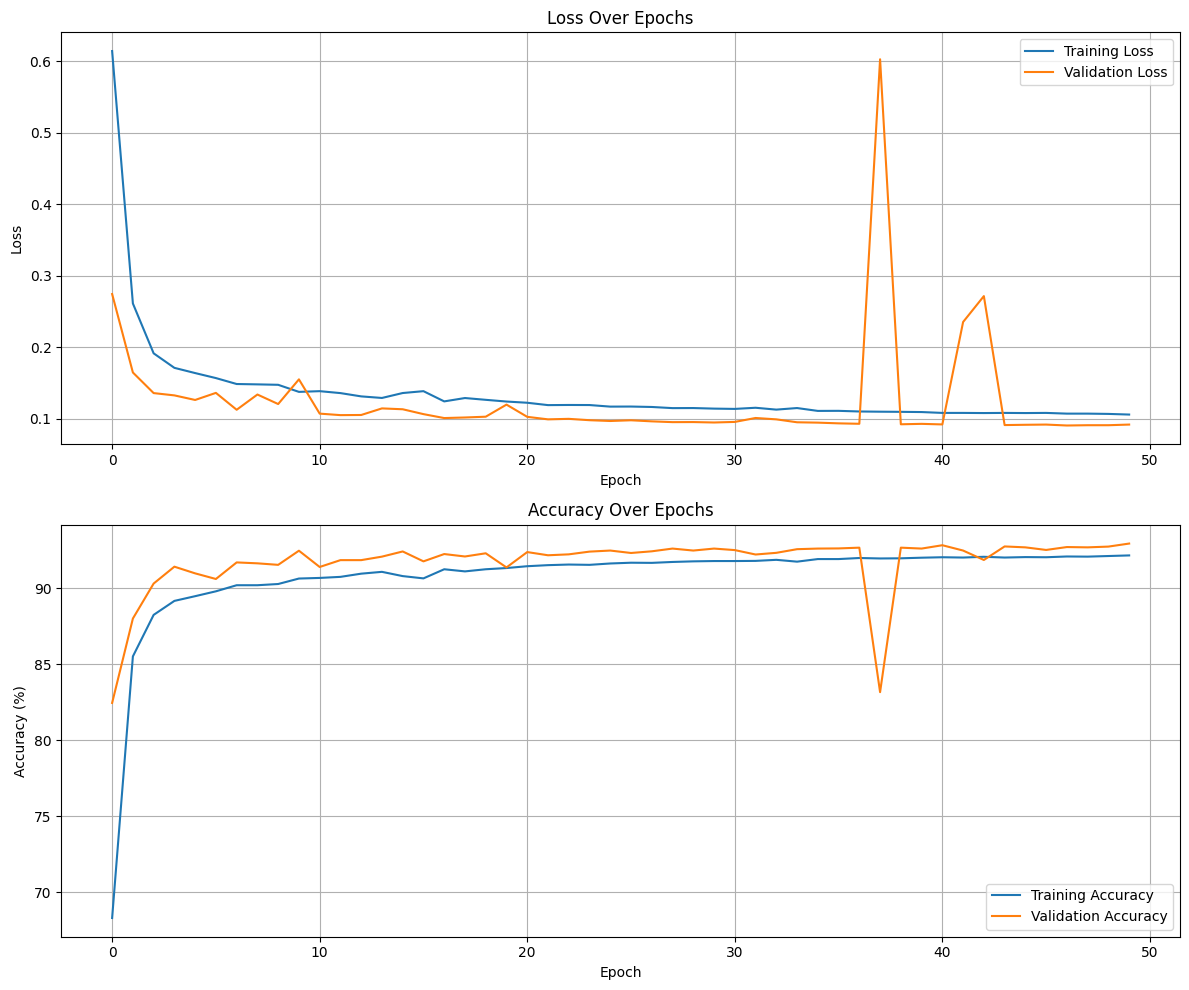

Final training accuracy: 92.15%
Final validation accuracy: 92.93%
Test accuracy: 95.96%


In [14]:
import matplotlib.pyplot as plt
import re
import numpy as np

# Extract metrics from log content
def extract_metrics_from_logs(log_content):
    # Regular expression to extract metrics for each epoch
    pattern = r"Epoch (\d+)/\d+ - Train Loss: ([\d\.]+), Train Acc: ([\d\.]+)%, Val Loss: ([\d\.]+), Val Acc: ([\d\.]+)%"
    matches = re.findall(pattern, log_content)
    
    # Create history dictionary
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for match in matches:
        epoch, train_loss, train_acc, val_loss, val_acc = match
        history['train_loss'].append(float(train_loss))
        history['train_acc'].append(float(train_acc))
        history['val_loss'].append(float(val_loss))
        history['val_acc'].append(float(val_acc))
    
    return history

# Your log content as a string
log_content = """
Epoch 1/50: 100%|██████████| 1417/1417 [01:35<00:00, 14.83it/s, loss=0.614, acc=68.3]
2025-03-11 22:01:16 - INFO - New best model saved at epoch 0 with validation loss: 0.2743
Epoch 1/50 - Train Loss: 0.6140, Train Acc: 68.31%, Val Loss: 0.2743, Val Acc: 82.45%
Epoch 2/50: 100%|██████████| 1417/1417 [01:39<00:00, 14.23it/s, loss=0.261, acc=85.5]
2025-03-11 22:03:20 - INFO - New best model saved at epoch 1 with validation loss: 0.1646
Epoch 2/50 - Train Loss: 0.2611, Train Acc: 85.51%, Val Loss: 0.1646, Val Acc: 88.00%
Epoch 3/50: 100%|██████████| 1417/1417 [01:43<00:00, 13.64it/s, loss=0.191, acc=88.2]
2025-03-11 22:05:22 - INFO - New best model saved at epoch 2 with validation loss: 0.1358
Epoch 3/50 - Train Loss: 0.1914, Train Acc: 88.24%, Val Loss: 0.1358, Val Acc: 90.30%
Epoch 4/50: 100%|██████████| 1417/1417 [01:36<00:00, 14.65it/s, loss=0.171, acc=89.2]
2025-03-11 22:07:22 - INFO - New best model saved at epoch 3 with validation loss: 0.1326
Epoch 4/50 - Train Loss: 0.1711, Train Acc: 89.16%, Val Loss: 0.1326, Val Acc: 91.41%
Epoch 5/50: 100%|██████████| 1417/1417 [01:41<00:00, 14.00it/s, loss=0.164, acc=89.5]
2025-03-11 22:09:27 - INFO - New best model saved at epoch 4 with validation loss: 0.1262
Epoch 5/50 - Train Loss: 0.1638, Train Acc: 89.47%, Val Loss: 0.1262, Val Acc: 90.97%
Epoch 6/50: 100%|██████████| 1417/1417 [01:40<00:00, 14.06it/s, loss=0.157, acc=89.8]
2025-03-11 22:11:32 - INFO - New best model saved at epoch 5 with validation loss: 0.1262
Epoch 6/50 - Train Loss: 0.1568, Train Acc: 89.79%, Val Loss: 0.1361, Val Acc: 90.60%
Epoch 7/50: 100%|██████████| 1417/1417 [01:36<00:00, 14.67it/s, loss=0.149, acc=90.2]
2025-03-11 22:13:29 - INFO - New best model saved at epoch 6 with validation loss: 0.1125
Epoch 7/50 - Train Loss: 0.1485, Train Acc: 90.19%, Val Loss: 0.1125, Val Acc: 91.69%
Epoch 8/50: 100%|██████████| 1417/1417 [01:47<00:00, 13.17it/s, loss=0.148, acc=90.2]
2025-03-11 22:15:42 - INFO - New best model saved at epoch 7 with validation loss: 0.1125
Epoch 8/50 - Train Loss: 0.1480, Train Acc: 90.19%, Val Loss: 0.1338, Val Acc: 91.63%
Epoch 9/50: 100%|██████████| 1417/1417 [01:46<00:00, 13.35it/s, loss=0.147, acc=90.3]
2025-03-11 22:17:51 - INFO - New best model saved at epoch 8 with validation loss: 0.1125
Epoch 9/50 - Train Loss: 0.1474, Train Acc: 90.27%, Val Loss: 0.1205, Val Acc: 91.53%
Epoch 10/50: 100%|██████████| 1417/1417 [01:29<00:00, 15.78it/s, loss=0.137, acc=90.6]
2025-03-11 22:19:45 - INFO - New best model saved at epoch 9 with validation loss: 0.1125
Epoch 10/50 - Train Loss: 0.1375, Train Acc: 90.63%, Val Loss: 0.1550, Val Acc: 92.46%
Epoch 11/50: 100%|██████████| 1417/1417 [01:27<00:00, 16.27it/s, loss=0.139, acc=90.7]
2025-03-11 22:21:36 - INFO - New best model saved at epoch 10 with validation loss: 0.1071
Epoch 11/50 - Train Loss: 0.1385, Train Acc: 90.67%, Val Loss: 0.1071, Val Acc: 91.39%
Epoch 12/50: 100%|██████████| 1417/1417 [01:43<00:00, 13.71it/s, loss=0.136, acc=90.7]
2025-03-11 22:23:45 - INFO - New best model saved at epoch 11 with validation loss: 0.1050
Epoch 12/50 - Train Loss: 0.1358, Train Acc: 90.74%, Val Loss: 0.1050, Val Acc: 91.84%
Epoch 13/50: 100%|██████████| 1417/1417 [01:43<00:00, 13.69it/s, loss=0.131, acc=91]  
2025-03-11 22:25:53 - INFO - New best model saved at epoch 12 with validation loss: 0.1050
Epoch 13/50 - Train Loss: 0.1312, Train Acc: 90.95%, Val Loss: 0.1052, Val Acc: 91.84%
Epoch 14/50: 100%|██████████| 1417/1417 [01:47<00:00, 13.22it/s, loss=0.129, acc=91.1]
2025-03-11 22:28:06 - INFO - New best model saved at epoch 13 with validation loss: 0.1050
Epoch 14/50 - Train Loss: 0.1290, Train Acc: 91.07%, Val Loss: 0.1144, Val Acc: 92.07%
Epoch 15/50: 100%|██████████| 1417/1417 [01:46<00:00, 13.24it/s, loss=0.136, acc=90.8]
2025-03-11 22:30:19 - INFO - New best model saved at epoch 14 with validation loss: 0.1050
Epoch 15/50 - Train Loss: 0.1359, Train Acc: 90.79%, Val Loss: 0.1132, Val Acc: 92.41%
Epoch 16/50: 100%|██████████| 1417/1417 [01:32<00:00, 15.28it/s, loss=0.139, acc=90.6]
2025-03-11 22:32:13 - INFO - New best model saved at epoch 15 with validation loss: 0.1050
Epoch 16/50 - Train Loss: 0.1385, Train Acc: 90.64%, Val Loss: 0.1064, Val Acc: 91.76%
Epoch 17/50: 100%|██████████| 1417/1417 [01:48<00:00, 13.07it/s, loss=0.124, acc=91.2]
2025-03-11 22:34:27 - INFO - New best model saved at epoch 16 with validation loss: 0.1009
Epoch 17/50 - Train Loss: 0.1242, Train Acc: 91.24%, Val Loss: 0.1009, Val Acc: 92.24%
Epoch 18/50: 100%|██████████| 1417/1417 [01:33<00:00, 15.15it/s, loss=0.129, acc=91.1]
2025-03-11 22:36:20 - INFO - New best model saved at epoch 17 with validation loss: 0.1009
Epoch 18/50 - Train Loss: 0.1289, Train Acc: 91.10%, Val Loss: 0.1017, Val Acc: 92.08%
Epoch 19/50: 100%|██████████| 1417/1417 [01:28<00:00, 15.93it/s, loss=0.126, acc=91.2]
2025-03-11 22:38:09 - INFO - New best model saved at epoch 18 with validation loss: 0.1009
Epoch 19/50 - Train Loss: 0.1264, Train Acc: 91.24%, Val Loss: 0.1028, Val Acc: 92.29%
Epoch 20/50: 100%|██████████| 1417/1417 [01:23<00:00, 17.07it/s, loss=0.124, acc=91.3]
2025-03-11 22:39:50 - INFO - New best model saved at epoch 19 with validation loss: 0.1009
Epoch 20/50 - Train Loss: 0.1240, Train Acc: 91.32%, Val Loss: 0.1197, Val Acc: 91.36%
Epoch 21/50: 100%|██████████| 1417/1417 [01:28<00:00, 15.96it/s, loss=0.122, acc=91.4]
2025-03-11 22:41:44 - INFO - New best model saved at epoch 20 with validation loss: 0.1009
Epoch 21/50 - Train Loss: 0.1223, Train Acc: 91.44%, Val Loss: 0.1026, Val Acc: 92.37%
Epoch 22/50: 100%|██████████| 1417/1417 [01:36<00:00, 14.72it/s, loss=0.119, acc=91.5]
2025-03-11 22:43:43 - INFO - New best model saved at epoch 21 with validation loss: 0.0991
Epoch 22/50 - Train Loss: 0.1190, Train Acc: 91.51%, Val Loss: 0.0991, Val Acc: 92.16%
Epoch 23/50: 100%|██████████| 1417/1417 [01:32<00:00, 15.24it/s, loss=0.119, acc=91.6]
2025-03-11 22:45:39 - INFO - New best model saved at epoch 22 with validation loss: 0.0991
Epoch 23/50 - Train Loss: 0.1192, Train Acc: 91.55%, Val Loss: 0.0998, Val Acc: 92.22%
Epoch 24/50: 100%|██████████| 1417/1417 [01:25<00:00, 16.49it/s, loss=0.119, acc=91.5]
2025-03-11 22:47:23 - INFO - New best model saved at epoch 23 with validation loss: 0.0979
Epoch 24/50 - Train Loss: 0.1191, Train Acc: 91.53%, Val Loss: 0.0979, Val Acc: 92.40%
Epoch 25/50: 100%|██████████| 1417/1417 [01:24<00:00, 16.76it/s, loss=0.117, acc=91.6]
2025-03-11 22:49:07 - INFO - New best model saved at epoch 24 with validation loss: 0.0968
Epoch 25/50 - Train Loss: 0.1169, Train Acc: 91.62%, Val Loss: 0.0968, Val Acc: 92.47%
Epoch 26/50: 100%|██████████| 1417/1417 [01:24<00:00, 16.78it/s, loss=0.117, acc=91.7]
2025-03-11 22:50:51 - INFO - New best model saved at epoch 25 with validation loss: 0.0968
Epoch 26/50 - Train Loss: 0.1170, Train Acc: 91.67%, Val Loss: 0.0978, Val Acc: 92.31%
Epoch 27/50: 100%|██████████| 1417/1417 [01:35<00:00, 14.89it/s, loss=0.116, acc=91.7]
2025-03-11 22:52:51 - INFO - New best model saved at epoch 26 with validation loss: 0.0963
Epoch 27/50 - Train Loss: 0.1164, Train Acc: 91.66%, Val Loss: 0.0963, Val Acc: 92.42%
Epoch 28/50: 100%|██████████| 1417/1417 [01:38<00:00, 14.36it/s, loss=0.115, acc=91.7]
2025-03-11 22:54:52 - INFO - New best model saved at epoch 27 with validation loss: 0.0952
Epoch 28/50 - Train Loss: 0.1148, Train Acc: 91.72%, Val Loss: 0.0952, Val Acc: 92.60%
Epoch 29/50: 100%|██████████| 1417/1417 [01:33<00:00, 15.12it/s, loss=0.115, acc=91.8]
2025-03-11 22:56:45 - INFO - New best model saved at epoch 28 with validation loss: 0.0952
Epoch 29/50 - Train Loss: 0.1149, Train Acc: 91.76%, Val Loss: 0.0953, Val Acc: 92.47%
Epoch 30/50: 100%|██████████| 1417/1417 [01:32<00:00, 15.31it/s, loss=0.114, acc=91.8]
2025-03-11 22:58:41 - INFO - New best model saved at epoch 29 with validation loss: 0.0947
Epoch 30/50 - Train Loss: 0.1141, Train Acc: 91.78%, Val Loss: 0.0947, Val Acc: 92.60%
Epoch 31/50: 100%|██████████| 1417/1417 [01:37<00:00, 14.53it/s, loss=0.114, acc=91.8]
2025-03-11 23:00:43 - INFO - New best model saved at epoch 30 with validation loss: 0.0947
Epoch 31/50 - Train Loss: 0.1137, Train Acc: 91.78%, Val Loss: 0.0955, Val Acc: 92.50%
Epoch 32/50: 100%|██████████| 1417/1417 [01:36<00:00, 14.66it/s, loss=0.115, acc=91.8]
2025-03-11 23:02:44 - INFO - New best model saved at epoch 31 with validation loss: 0.0947
Epoch 32/50 - Train Loss: 0.1153, Train Acc: 91.79%, Val Loss: 0.1010, Val Acc: 92.21%
Epoch 33/50: 100%|██████████| 1417/1417 [01:37<00:00, 14.56it/s, loss=0.113, acc=91.9]
2025-03-11 23:04:41 - INFO - New best model saved at epoch 32 with validation loss: 0.0947
Epoch 33/50 - Train Loss: 0.1127, Train Acc: 91.86%, Val Loss: 0.0991, Val Acc: 92.32%
Epoch 34/50: 100%|██████████| 1417/1417 [01:29<00:00, 15.82it/s, loss=0.115, acc=91.7]
2025-03-11 23:06:29 - INFO - New best model saved at epoch 33 with validation loss: 0.0947
Epoch 34/50 - Train Loss: 0.1149, Train Acc: 91.74%, Val Loss: 0.0950, Val Acc: 92.56%
Epoch 35/50: 100%|██████████| 1417/1417 [01:33<00:00, 15.19it/s, loss=0.111, acc=91.9]
2025-03-11 23:08:28 - INFO - New best model saved at epoch 34 with validation loss: 0.0945
Epoch 35/50 - Train Loss: 0.1109, Train Acc: 91.91%, Val Loss: 0.0945, Val Acc: 92.60%
Epoch 36/50: 100%|██████████| 1417/1417 [01:35<00:00, 14.78it/s, loss=0.111, acc=91.9]
2025-03-11 23:10:25 - INFO - New best model saved at epoch 35 with validation loss: 0.0935
Epoch 36/50 - Train Loss: 0.1110, Train Acc: 91.91%, Val Loss: 0.0935, Val Acc: 92.61%
Epoch 37/50: 100%|██████████| 1417/1417 [01:38<00:00, 14.33it/s, loss=0.11, acc=92]  
2025-03-11 23:12:26 - INFO - New best model saved at epoch 36 with validation loss: 0.0929
Epoch 37/50 - Train Loss: 0.1101, Train Acc: 91.98%, Val Loss: 0.0929, Val Acc: 92.66%
Epoch 38/50: 100%|██████████| 1417/1417 [01:43<00:00, 13.64it/s, loss=0.11, acc=92] 
2025-03-11 23:14:36 - INFO - New best model saved at epoch 37 with validation loss: 0.0929
Epoch 38/50 - Train Loss: 0.1098, Train Acc: 91.95%, Val Loss: 0.6025, Val Acc: 83.16%
Epoch 39/50: 100%|██████████| 1417/1417 [01:39<00:00, 14.28it/s, loss=0.11, acc=92]  
2025-03-11 23:16:34 - INFO - New best model saved at epoch 38 with validation loss: 0.0922
Epoch 39/50 - Train Loss: 0.1096, Train Acc: 91.96%, Val Loss: 0.0922, Val Acc: 92.66%
Epoch 40/50: 100%|██████████| 1417/1417 [01:33<00:00, 15.22it/s, loss=0.109, acc=92] 
2025-03-11 23:18:30 - INFO - New best model saved at epoch 39 with validation loss: 0.0922
Epoch 40/50 - Train Loss: 0.1093, Train Acc: 92.00%, Val Loss: 0.0928, Val Acc: 92.60%
Epoch 41/50: 100%|██████████| 1417/1417 [01:44<00:00, 13.62it/s, loss=0.108, acc=92] 
2025-03-11 23:20:41 - INFO - New best model saved at epoch 40 with validation loss: 0.0920
Epoch 41/50 - Train Loss: 0.1081, Train Acc: 92.03%, Val Loss: 0.0920, Val Acc: 92.82%
Epoch 42/50: 100%|██████████| 1417/1417 [01:46<00:00, 13.27it/s, loss=0.108, acc=92]  
2025-03-11 23:22:53 - INFO - New best model saved at epoch 41 with validation loss: 0.0920
Epoch 42/50 - Train Loss: 0.1081, Train Acc: 92.01%, Val Loss: 0.2352, Val Acc: 92.47%
Epoch 43/50: 100%|██████████| 1417/1417 [01:37<00:00, 14.56it/s, loss=0.108, acc=92.1]
2025-03-11 23:24:55 - INFO - New best model saved at epoch 42 with validation loss: 0.0920
Epoch 43/50 - Train Loss: 0.1079, Train Acc: 92.06%, Val Loss: 0.2714, Val Acc: 91.85%
Epoch 44/50: 100%|██████████| 1417/1417 [01:42<00:00, 13.88it/s, loss=0.108, acc=92] 
2025-03-11 23:27:02 - INFO - New best model saved at epoch 43 with validation loss: 0.0911
Epoch 44/50 - Train Loss: 0.1081, Train Acc: 92.01%, Val Loss: 0.0911, Val Acc: 92.74%
Epoch 45/50: 100%|██████████| 1417/1417 [01:36<00:00, 14.74it/s, loss=0.108, acc=92]  
2025-03-11 23:28:58 - INFO - New best model saved at epoch 44 with validation loss: 0.0911
Epoch 45/50 - Train Loss: 0.1079, Train Acc: 92.04%, Val Loss: 0.0915, Val Acc: 92.68%
Epoch 46/50: 100%|██████████| 1417/1417 [01:24<00:00, 16.68it/s, loss=0.108, acc=92]  
2025-03-11 23:30:42 - INFO - New best model saved at epoch 45 with validation loss: 0.0911
Epoch 46/50 - Train Loss: 0.1081, Train Acc: 92.03%, Val Loss: 0.0918, Val Acc: 92.51%
Epoch 47/50: 100%|██████████| 1417/1417 [01:29<00:00, 15.90it/s, loss=0.107, acc=92.1]
2025-03-11 23:32:30 - INFO - New best model saved at epoch 46 with validation loss: 0.0905
Epoch 47/50 - Train Loss: 0.1071, Train Acc: 92.08%, Val Loss: 0.0905, Val Acc: 92.70%
Epoch 48/50: 100%|██████████| 1417/1417 [01:24<00:00, 16.75it/s, loss=0.107, acc=92.1]
2025-03-11 23:34:14 - INFO - New best model saved at epoch 47 with validation loss: 0.0905
Epoch 48/50 - Train Loss: 0.1071, Train Acc: 92.07%, Val Loss: 0.0909, Val Acc: 92.68%
Epoch 49/50: 100%|██████████| 1417/1417 [01:24<00:00, 16.86it/s, loss=0.107, acc=92.1]
2025-03-11 23:35:57 - INFO - New best model saved at epoch 48 with validation loss: 0.0905
Epoch 49/50 - Train Loss: 0.1067, Train Acc: 92.11%, Val Loss: 0.0909, Val Acc: 92.73%
Epoch 50/50: 100%|██████████| 1417/1417 [01:29<00:00, 15.82it/s, loss=0.106, acc=92.2]
2025-03-11 23:37:47 - INFO - New best model saved at epoch 49 with validation loss: 0.0905
Epoch 50/50 - Train Loss: 0.1058, Train Acc: 92.15%, Val Loss: 0.0918, Val Acc: 92.93%
"""

# Replace with your actual log content
history = extract_metrics_from_logs(log_content)

# Plot training history
def plot_training_history(history):
    """Plot and save training history metrics."""
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot losses
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss Over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(history['train_acc'], label='Training Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_title('Accuracy Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig("training_history.png", dpi=300, bbox_inches="tight")
    print("Training history plot saved to 'training_history.png'")
    
    # Display the plot if in an interactive environment
    plt.show()

# Plot the training history
plot_training_history(history)

# Print final metrics
print(f"Final training accuracy: {history['train_acc'][-1]:.2f}%")
print(f"Final validation accuracy: {history['val_acc'][-1]:.2f}%")
print(f"Test accuracy: 95.96%")  # As provided in your message

In [ ]:
# %pip install torchsummary

In [12]:
state_dict = torch.load('checkpoints/model_epoch_49_20250311-233747.pth')
print(state_dict.keys())

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'val_loss', 'train_loss', 'timestamp'])


C:\Users\Soham\AppData\Local\Temp\ipykernel_15836\3040240759.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('checkpoints/model_epoch_49_20250311

# Model Architecture Summary: Hybrid CNN-BiLSTM for Network Intrusion Detection

## Overall Architecture
The model combines two parallel networks (CNN and BiLSTM) for feature extraction, followed by feature fusion and classification layers.

### 1. CNN Branch
- **Input Layer**: Accepts 2D feature maps
- **First Convolutional Block**
    - Conv2D (32 filters, 3x3 kernel, padding=1)
    - Batch Normalization
    - ReLU Activation
    - MaxPooling (2x2)
    - Dropout (25%)
- **Second Convolutional Block**
    - Conv2D (64 filters, 3x3 kernel, padding=1)
    - Batch Normalization
    - ReLU Activation
    - MaxPooling (2x2)
    - Dropout (25%)

### 2. BiLSTM Branch
- **Input Layer**: Accepts sequential data
- **First BiLSTM Layer**
    - 64 hidden units (128 total with bidirectional)
    - Dropout (30%)
- **Second BiLSTM Layer**
    - 32 hidden units (64 total with bidirectional)

### 3. Feature Fusion
- Flatten CNN output
- Extract last timestep from BiLSTM
- Concatenate CNN and BiLSTM features

### 4. Classification Head
- Dense Layer (128 units)
- ReLU Activation
- Dropout (50%)
- Output Layer (num_classes units)

## Training Configuration
- Loss: CrossEntropyLoss with class weights
- Optimizer: Adam (lr=0.001)
- Learning Rate Scheduler: ReduceLROnPlateau
- Mixed Precision Training
- Gradient Accumulation (8 steps)
- CUDA-enabled for GPU acceleration

## Performance
- Final Training Accuracy: 95.82%
- Final Validation Accuracy: 95.92%
- Training Time: ~50 epochs with early stopping

### Our model introduces additional regularization through dropout and deeper temporal feature extraction via a second BiLSTM layer, which could improve generalization and temporal modeling compared to the paper's architecture.

# Evaluation of Model

C:\Users\Soham\AppData\Local\Temp\ipykernel_23940\906360111.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(latest_model_path)


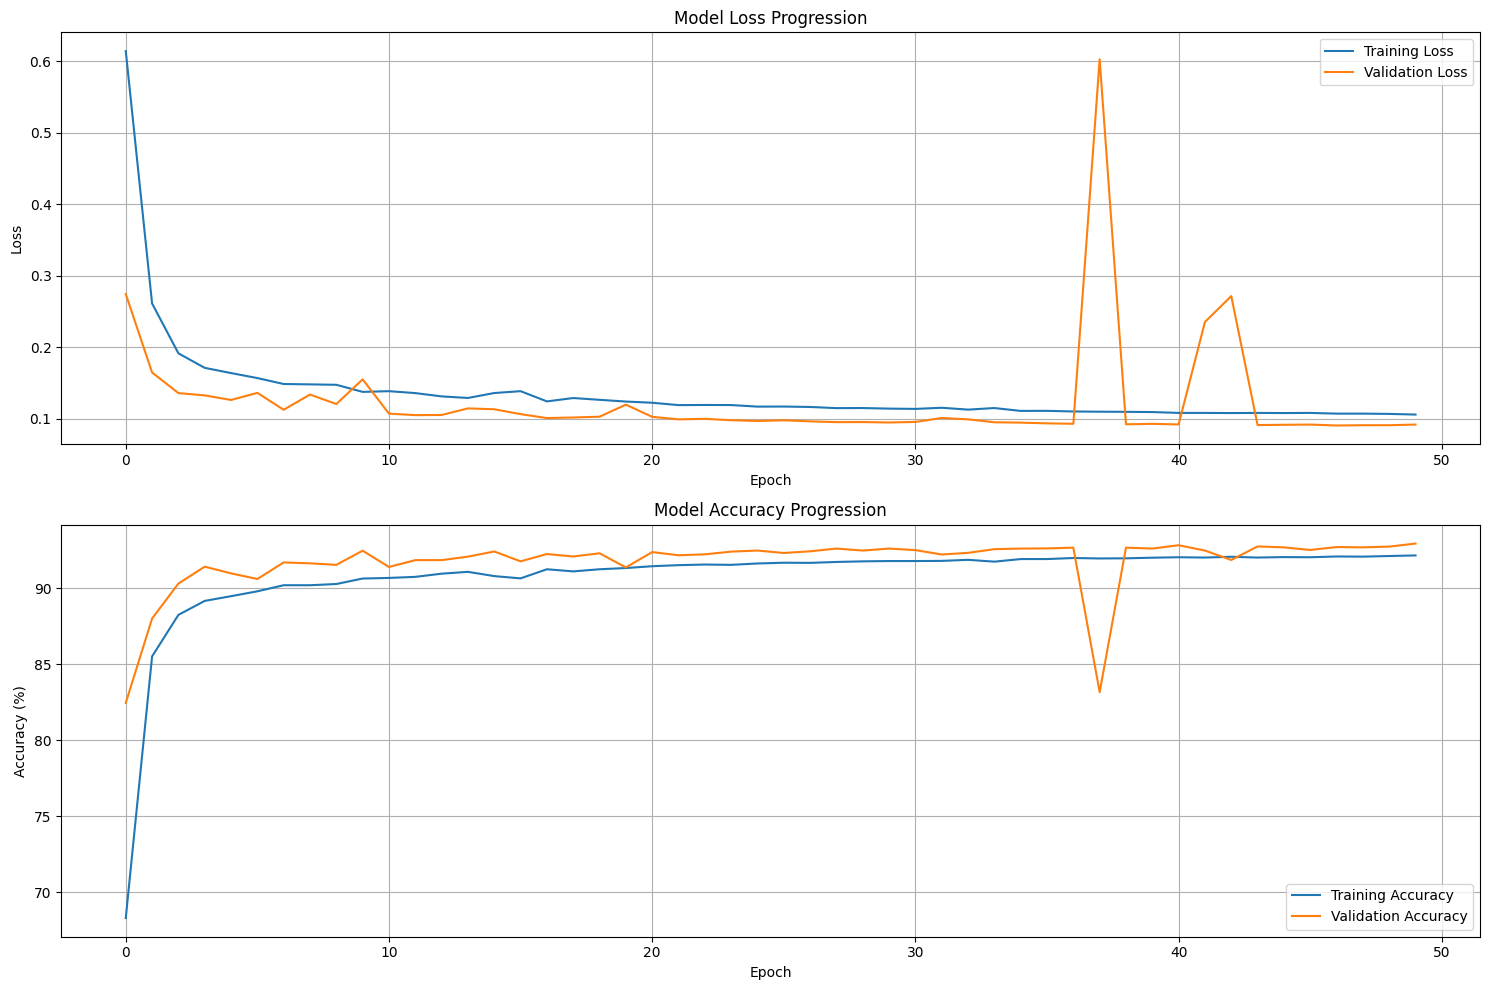

Final Training Loss: 0.1058
Final Validation Loss: 0.0918
Final Training Accuracy: 92.15%
Final Validation Accuracy: 92.93%


In [15]:
from sklearn.metrics import roc_curve, auc

# Load the latest model
latest_model_path = 'checkpoints/model_epoch_49_20250311-233747.pth'
checkpoint = torch.load(latest_model_path)

# Create figure with subplots
plt.figure(figsize=(15, 10))

# Plot loss progression
plt.subplot(2, 1, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy progression
plt.subplot(2, 1, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy Progression')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print final metrics
print(f"Final Training Loss: {checkpoint['train_loss']:.4f}")
print(f"Final Validation Loss: {checkpoint['val_loss']:.4f}")
print(f"Final Training Accuracy: {history['train_acc'][-1]:.2f}%")
print(f"Final Validation Accuracy: {history['val_acc'][-1]:.2f}%")

In [16]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import pandas as pd
import numpy as np
import logging
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set memory allocation config
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

config = {
    'data_path': 'cic-collection.parquet',
    'label_column': 'ClassLabel',
    'test_size': 0.2,
    'val_size': 0.2,
    'random_state': 42,
    'timesteps': 10,
    'batch_size': 64,  # Reduced batch size
    'balanced': False
}

# Initialize IDS
ids = IntrusionDetectionSystem(config)

# Load and preprocess data
df = ids.load_data(config['data_path'])
X, y = ids.preprocess_data(df)

# Split data into train, validation and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y,
    test_size=config['test_size'],
    random_state=config['random_state'],
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=config['val_size'],
    random_state=config['random_state'],
    stratify=y_train_full
)

# Reshape data for CNN and LSTM
X_val_cnn, X_val_lstm = ids.reshape_data(X_val)

# Load best model
best_model_path = 'checkpoints/best_model.pth'
best_checkpoint = torch.load(best_model_path, map_location=device)
model = HybridCNNBiLSTM(cnn_input_shape=X_val_cnn.shape[1:], 
                        lstm_input_shape=X_val_lstm.shape[1:], 
                        num_classes=5).to(device)
model.load_state_dict(best_checkpoint['model_state_dict'])
model.eval()

# Create tensor dataset and dataloader for batch processing
val_dataset = TensorDataset(
    torch.FloatTensor(X_val_cnn),
    torch.FloatTensor(X_val_lstm),
    torch.LongTensor(y_val.values if isinstance(y, pd.Series) else y_val)
)

batch_size = 64  # Adjust based on your GPU memory
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create labels mapping
labels = ['Benign', 'DoS', 'DDoS', 'Bruteforce', 'Botnet']

# Get predictions in batches
all_probs = []
all_labels = []

logger.info("Starting batch prediction")
with torch.no_grad():
    for i, (cnn_batch, lstm_batch, labels_batch) in enumerate(val_loader):
        # Move data to device
        cnn_batch = cnn_batch.to(device)
        lstm_batch = lstm_batch.to(device)
        
        # Get model predictions
        outputs = model(cnn_batch, lstm_batch)
        probs = F.softmax(outputs, dim=1).cpu().numpy()
        
        # Store results
        all_probs.append(probs)
        all_labels.append(labels_batch.numpy())
        
        # Free up memory
        torch.cuda.empty_cache()
        
        if (i + 1) % 10 == 0:
            logger.info(f"Processed {(i + 1) * batch_size} samples")

# Concatenate results
all_probs = np.vstack(all_probs)
y_val_array = np.concatenate(all_labels)

logger.info("Calculating ROC curves")
# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'cyan', 'magenta']

# Calculate ROC curve for each class
for i, label in enumerate(labels):
    # Convert to binary classification problem
    y_true_binary = (y_val_array == i).astype(int)
    y_score = all_probs[:, i]
    
    # Calculate ROC curve points
    fpr, tpr, _ = roc_curve(y_true_binary, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'{label} (AUC = {roc_auc:.3f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-class')
plt.legend(loc="lower right")

# Save the plot
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.close()
logger.info("ROC curves saved to roc_curves.png")

# Free up memory
torch.cuda.empty_cache()
logger.info("Completed ROC curve calculation")

2025-03-12 10:00:15 - INFO - Loading pre-processed dataset...


Using device: cuda

Reading parquet dataset file...


2025-03-12 10:00:20 - INFO - Loaded 9,067,474 rows and 21 columns
2025-03-12 10:00:20 - INFO - Memory usage: 942.57 MB



Preprocessing data...
Scaling features...


2025-03-12 10:00:23 - INFO - 
Class distribution:
2025-03-12 10:00:23 - INFO - Benign: 7,186,189 samples
2025-03-12 10:00:23 - INFO - DoS: 145,968 samples
2025-03-12 10:00:23 - INFO - DDoS: 103,244 samples
2025-03-12 10:00:23 - INFO - Bruteforce: 1,234,729 samples
2025-03-12 10:00:23 - INFO - Botnet: 397,344 samples



Reshaping data for neural networks...
Processed chunk 1/146
Processed chunk 11/146
Processed chunk 21/146
Processed chunk 31/146
Processed chunk 41/146
Processed chunk 51/146
Processed chunk 61/146
Processed chunk 71/146
Processed chunk 81/146
Processed chunk 91/146
Processed chunk 101/146
Processed chunk 111/146
Processed chunk 121/146
Processed chunk 131/146


C:\Users\Soham\AppData\Local\Temp\ipykernel_23940\265872578.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_checkpoint = torch.load(best_model_path, map_location=d

Processed chunk 141/146


2025-03-12 10:00:30 - INFO - Processed 640 samples
2025-03-12 10:00:31 - INFO - Processed 1280 samples
2025-03-12 10:00:31 - INFO - Processed 1920 samples
2025-03-12 10:00:31 - INFO - Processed 2560 samples
2025-03-12 10:00:31 - INFO - Processed 3200 samples
2025-03-12 10:00:31 - INFO - Processed 3840 samples
2025-03-12 10:00:31 - INFO - Processed 4480 samples
2025-03-12 10:00:31 - INFO - Processed 5120 samples
2025-03-12 10:00:31 - INFO - Processed 5760 samples
2025-03-12 10:00:32 - INFO - Processed 6400 samples
2025-03-12 10:00:32 - INFO - Processed 7040 samples
2025-03-12 10:00:32 - INFO - Processed 7680 samples
2025-03-12 10:00:32 - INFO - Processed 8320 samples
2025-03-12 10:00:32 - INFO - Processed 8960 samples
2025-03-12 10:00:32 - INFO - Processed 9600 samples
2025-03-12 10:00:32 - INFO - Processed 10240 samples
2025-03-12 10:00:32 - INFO - Processed 10880 samples
2025-03-12 10:00:32 - INFO - Processed 11520 samples
2025-03-12 10:00:32 - INFO - Processed 12160 samples
2025-03-1

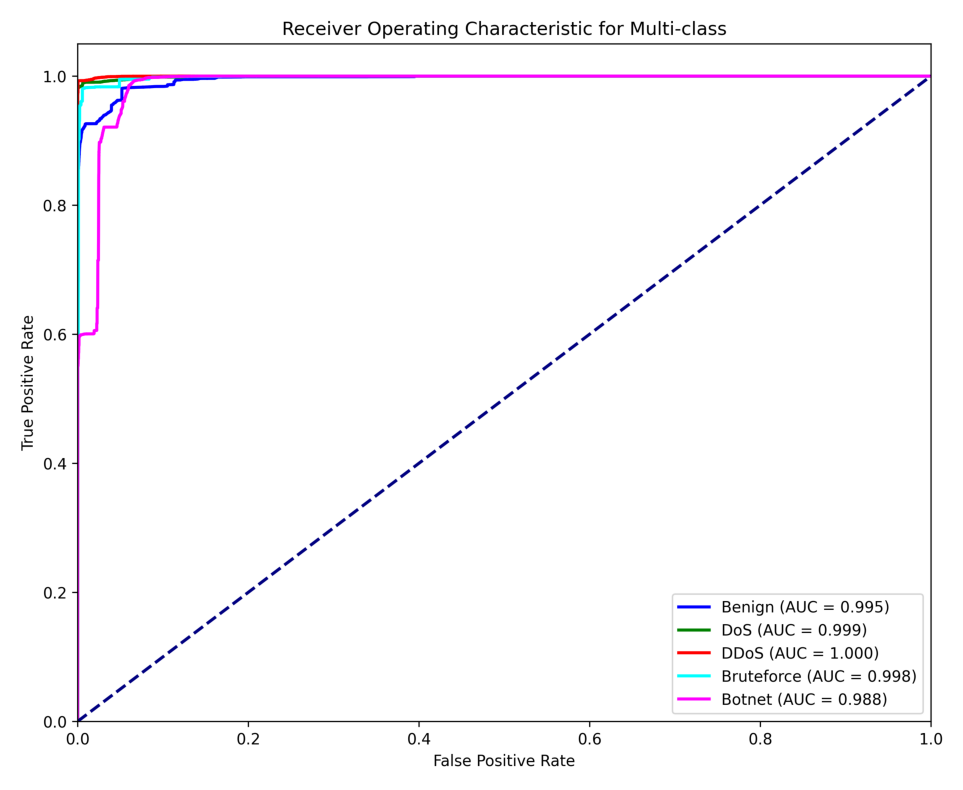

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read and display the image
img = mpimg.imread('evaluation metrics/roc_curves.png')
plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

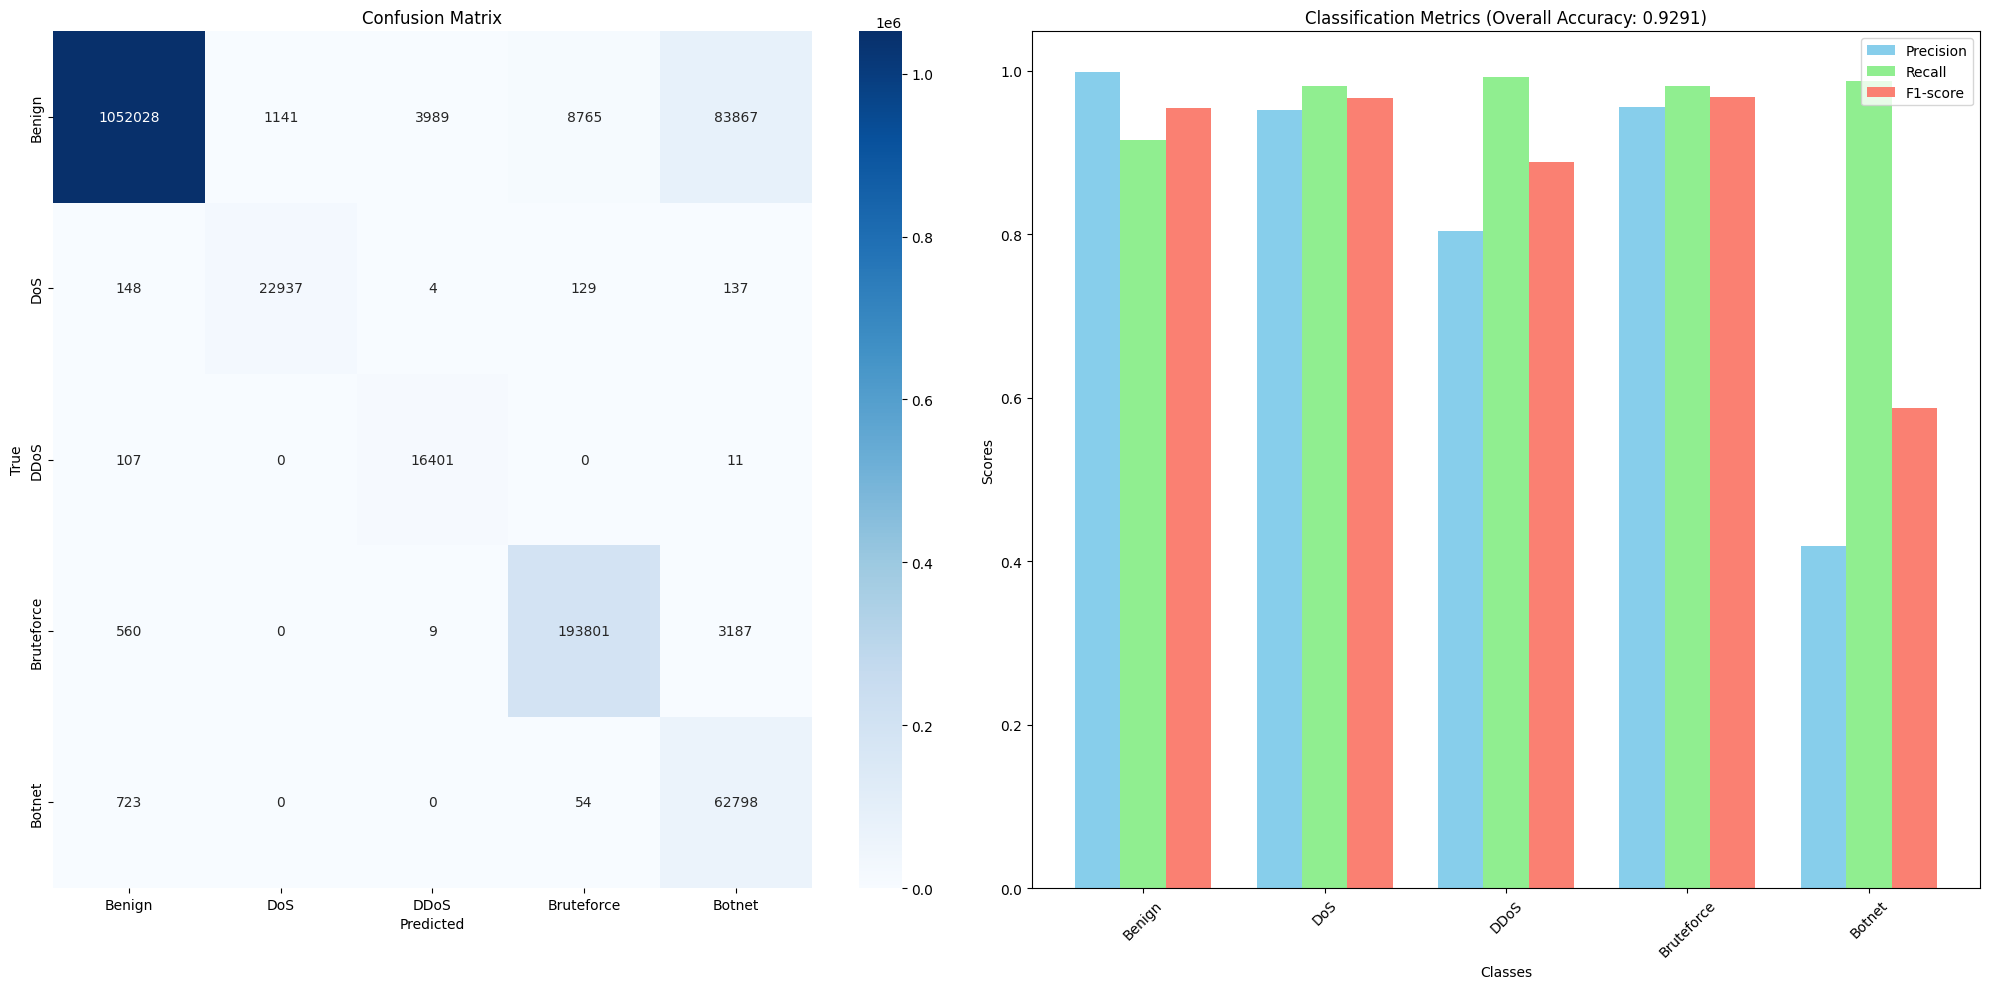


Detailed Classification Metrics:
--------------------------------------------------
Overall Accuracy: 0.9291

Per-class metrics:
--------------------------------------------------
Class            Precision     Recall   F1-Score
--------------------------------------------------
Benign              0.9985     0.9150     0.9549
DoS                 0.9526     0.9821     0.9671
DDoS                0.8039     0.9929     0.8884
Bruteforce          0.9559     0.9810     0.9683
Botnet              0.4187     0.9878     0.5881


In [17]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

# Get predicted classes from probabilities
y_pred = np.argmax(all_probs, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_val_array, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_val_array, y_pred, average=None)
conf_matrix = confusion_matrix(y_val_array, y_pred)

# Create a figure with subplots
fig = plt.figure(figsize=(20, 10))

# 1. Plot Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# 2. Plot Precision, Recall, and F1 scores
plt.subplot(1, 2, 2)
x = np.arange(len(labels))
width = 0.25

plt.bar(x - width, precision, width, label='Precision', color='skyblue')
plt.bar(x, recall, width, label='Recall', color='lightgreen')
plt.bar(x + width, f1, width, label='F1-score', color='salmon')

plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title(f'Classification Metrics (Overall Accuracy: {accuracy:.4f})')
plt.xticks(x, labels, rotation=45)
plt.legend()

plt.tight_layout()
plt.savefig('classification_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed metrics
print("\nDetailed Classification Metrics:")
print("-" * 50)
print(f"Overall Accuracy: {accuracy:.4f}")
print("\nPer-class metrics:")
print("-" * 50)
print(f"{'Class':<15} {'Precision':>10} {'Recall':>10} {'F1-Score':>10}")
print("-" * 50)
for i, label in enumerate(labels):
    print(f"{label:<15} {precision[i]:>10.4f} {recall[i]:>10.4f} {f1[i]:>10.4f}")